<a href="https://colab.research.google.com/github/Richar-Moreno/Robot-Trading-Bot/blob/main/1_1_Challenge_Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robot Trading:

The objective of the following project is to implement different data techniques to create a robot that can provide us with different insights and a suggested decision to buy, sell or hold our bitcoins, taking into account real time data taken from yahoo finance and coinmarketcap.com.

It is divided into the following 6 stages:

## 1.Setting Up the Environment:

In this section we will import the relevant and necessary libraries to realize the project.

In [54]:
# Global Variables: The following variables will be used in all phases of the project

global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

In [55]:
# Importing the libraries

import numpy as np
import pandas as pd
import matplotlib as plt

In [56]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1


## 2.Getting the Raw Data:

In this section we are going to extract the information from Yahoo Finance and we are going to do web scraping to get some insights from coinmarketcap.com.

### 2.1. Historic Bitcoin Data.

In [57]:
import yfinance as yf

#Creating the first function,
#it will redefine the global variables and retrieve the historical bitcoin price data in dollars (BTC-USD) for the last 7 days in 5-minute intervals.

def importar_base_bitcoin():
  # Global Variables: The following variables will be used in all phases of the project
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  # Definition of the BTC symbol in dollars
  btc_symbol = "BTC-USD"

  # Definition of the time interval (5 minutes) and the time period (last 7 days)
  interval_time = "5m" # Five minutes from the yahoo finance documentation
  Time_period = "7d" # Seven days from the yahoo finance documentation

  # Download of retrieved historical data
  df_bitcoin = pd.DataFrame((yf.Ticker(btc_symbol)).history(period=Time_period,interval=interval_time))

In [58]:
#Display the bitcoin historical price base
importar_base_bitcoin()
df_bitcoin.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-23 00:00:00+00:00,30002.443359,30002.443359,29939.513672,29950.691406,0,0.0,0.0
2023-10-23 00:05:00+00:00,29968.242188,29976.166016,29949.933594,29949.933594,19917824,0.0,0.0
2023-10-23 00:10:00+00:00,29957.041016,29987.125000,29957.041016,29965.908203,19190784,0.0,0.0
2023-10-23 00:15:00+00:00,29979.537109,29979.537109,29965.908203,29965.908203,0,0.0,0.0
2023-10-23 00:20:00+00:00,29975.019531,29975.019531,29928.232422,29928.232422,5450752,0.0,0.0


### 2.2. Bitcoin trend indicators

In [95]:
def extraer_tendencias():
  # Global Variables: The following variables will be used in all phases of the project

  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  #Importing the web scrapping library
  from bs4 import BeautifulSoup
  import requests

  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36 OPR/102.0.0.0'}
  url = 'https://coinmarketcap.com/es/'
  respuesta = requests.get(url, headers = headers)
  s = BeautifulSoup(respuesta.content, features = 'lxml')

  # Partial match for class attribute (matches variations)

  div_element = s.find('div', {'class': ['sc-a0353bbc-0 gDrtaY rise','sc-a0353bbc-0 gDrtaY','sc-a0353bbc-0 gDrtaY fall']})
  div_element2 = s.find('span', {'class': ['sc-d55c02b-0 gUnzUB','sc-d55c02b-0 iwhBxy']}) #

  # Extract the text from the span element

  span_element = div_element.find('span')
  span_element2 = div_element2.find('span')

  variacion = span_element2.get('class')

  #var = div_element2.text.strip()

  #We extract the text content from the span element using .text, which returns the text contained within the span element.
  #We use .strip() to remove any leading or trailing whitespace, ensuring that we obtain the clean price value without unwanted spaces.

  price = span_element.text.strip()

  precio_actual = float(price.replace("$","").replace(".","").replace(",",""))

  variacion = str(variacion)

  if variacion == "['icon-Caret-up']":
    tendencia = "alta"
  elif variacion == "['icon-Caret-down']":
    tendencia = "baja"
  else:
    tendencia = ""

In [96]:
extraer_tendencias()
print('Bitcoin Price: ', precio_actual)
print('Tendencia: ', tendencia)

Bitcoin Price:  3440216.0
Tendencia:  baja


## 3.Data cleaning:

In this section we will describe our retrieved data and clean the outliers, and all noise from it.

### 3.1. Data Exploration and Preprocessing

In this section, we will perform an initial exploration and preprocessing of our DataFrame, which includes the following steps:

**1. Elimination of Duplicate Indexes:** We will remove duplicate indexes, ensuring that each index is unique.

**2. Handling Null Values in 'Close' Column:** Any null values in the 'Close' column will be dealt with appropriately.

**3. Validation and Treatment of Zero Values in 'Volume' Column:** We will verify and handle instances where the 'Volume' column contains zero values.

**4. Identification of Outliers:** We will identify and address any outliers present in the dataset.

**5. Outlier Removal:** If necessary, outliers will be removed from the dataset to ensure data integrity.

By following these steps, we will prepare the DataFrame for further analysis and modeling.

In [61]:
# Dataframe Information
df_bitcoin_limpio = df_bitcoin.copy()
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1901 entries, 2023-10-23 00:00:00+00:00 to 2023-10-29 16:05:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1901 non-null   float64
 1   High          1901 non-null   float64
 2   Low           1901 non-null   float64
 3   Close         1901 non-null   float64
 4   Volume        1901 non-null   int64  
 5   Dividends     1901 non-null   float64
 6   Stock Splits  1901 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 118.8 KB


In [62]:
# Elimination of Duplicate Indexes
df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]
print(df_bitcoin.shape, df_bitcoin_limpio.shape)

(1901, 7) (1901, 7)


In [63]:
# Handling Null Values in 'Close' Column

# Deleting the rows with null values in the column 'Close'
df_bitcoin_limpio = df_bitcoin_limpio.dropna(subset=['Close'])

print(df_bitcoin.shape, df_bitcoin_limpio.shape)

(1901, 7) (1901, 7)


In [64]:
# Validation and Treatment of Zero Values in 'Volume' Column:

# Deleting rows with Volume <= 0
df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

print(df_bitcoin.shape, df_bitcoin_limpio.shape)

(1901, 7) (853, 7)


<Axes: >

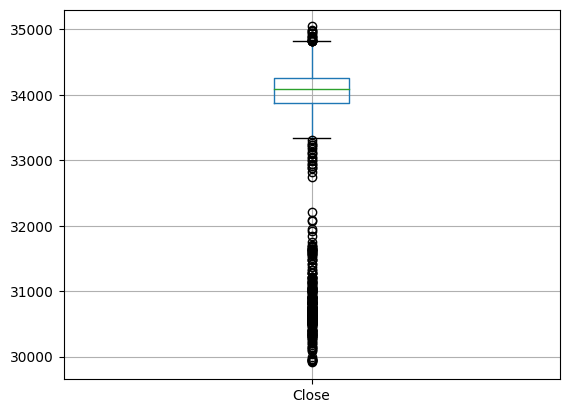

In [65]:
#Identification of outliers in the original dataframe
df_bitcoin.boxplot(['Close'])

<Axes: >

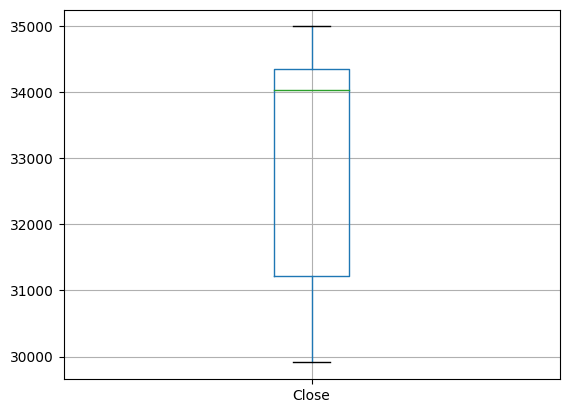

In [66]:
#Identification of outliers in the treated dataframe
df_bitcoin_limpio.boxplot(['Close'])

<Axes: >

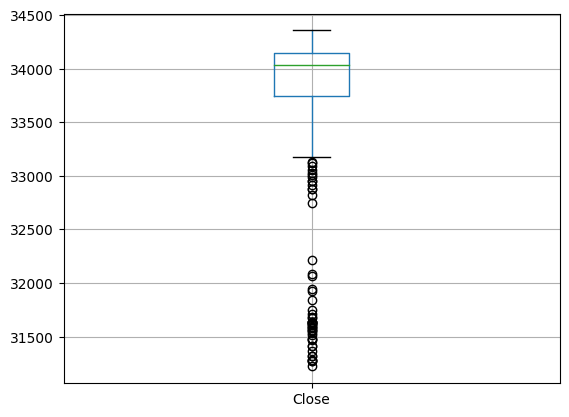

In [67]:
# Calculate the first quartile (Q1) and third quartile (Q3) of the 'Close' column
Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
Q3 = df_bitcoin_limpio['Close'].quantile(0.75)

# Filter the records where the 'Close' is between Q1 and Q3
df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= Q1) & (df_bitcoin_limpio['Close'] <= Q3)]

df_bitcoin_limpio.boxplot(['Close'])

### 3.2. Data Cleaning and Mean Calculation Function
In this section, we will create a comprehensive function that performs the following tasks:

**1. Data Cleaning:** The function will handle outlier detection, duplicate index removal, and null value elimination in the 'Close' column.

**2. Price Mean Calculation:** After the data cleaning steps, the function will calculate the mean of the 'Close' column.

This function will simplify the data cleaning process and provide the mean value of the 'Close' column as its output.

In [68]:
def limpieza_datos():
  # Global Variables: The following variables will be used in all phases of the project

  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  #Creating the copy of the original dataframe
  df_bitcoin_limpio = df_bitcoin.copy()

  # Elimination of Duplicate Indexes
  df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]

  # Handling Null Values in 'Close' Column

  # Deleting the rows with null values in the column 'Close'
  df_bitcoin_limpio = df_bitcoin_limpio.dropna(subset=['Close'])

  # Validation and Treatment of Zero Values in 'Volume' Column:

  # Deleting rows with Volume <= 0
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

  # Calculate the first quartile (Q1) and third quartile (Q3) of the 'Close' column
  Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  Q3 = df_bitcoin_limpio['Close'].quantile(0.75)

  # Filter the records where the 'Close' is between Q1 and Q3
  df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= Q1) & (df_bitcoin_limpio['Close'] <= Q3)]

  # Calculate the mean price of 'Close' price:

  media_bitcoin = df_bitcoin_limpio['Close'].mean()

  return media_bitcoin

In [69]:
limpieza_datos()

33755.5876299034

## 4.Decision Making:

In this section we will perform an algorithm with the retrieved information that will make the decision: wait, buy or sell the bitcoins.

In [70]:
def tomar_decisiones():
  # Global Variables: The following variables will be used in all phases of the project

  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  # Bbased on the following decision criteria:
  # If the current price is greater than or equal to the average price and the trend is downward, set the value to 'Sell'.
  # If the current price is less than the average price and the trend is upward, set the value to 'Buy'.
  # If neither of the two conditions above is met, set the value to 'Wait'.

  if (precio_actual >= limpieza_datos()) & (tendencia == 'baja'):
    algoritmo_decision = 'Vender'
  elif (precio_actual < limpieza_datos()) & (tendencia == 'alta'):
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'

  return algoritmo_decision



In [71]:
tomar_decisiones()

'Vender'

##5. Visualization:

We will display the information in a good way, which provide us with all the time series, media and decision in a single line chart.

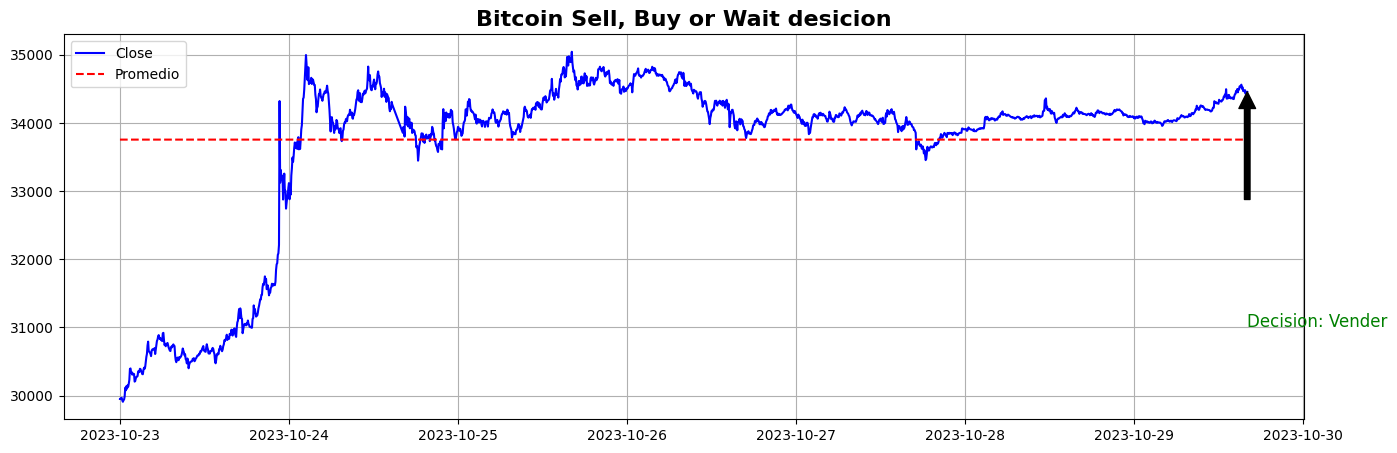

In [87]:
import matplotlib.pyplot as plt

# Define the 'visualizacion()' function
def visualizacion():
  # Global Variables: The following variables will be used in all phases of the project

  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision, color_decision

  if algoritmo_decision == 'Vender':
    color_decision = 'green'
  elif algoritmo_decision =='Comprar':
    color_decision = 'red'
  else:
    color_decision = 'black'


  # Add a new column to the original DataFrame 'df_bitcoin' with the value of 'media_bitcoin'
  df_bitcoin['Promedio'] = media_bitcoin

  # Set the size of the plot to 16x5
  plt.figure(figsize=(16, 5))

  # Add a title to the plot
  plt.title("Bitcoin Sell, Buy or Wait desicion", fontsize = 16, weight = 'bold')

  # Plot the 'Close' column from the 'df_bitcoin' DataFrame
  #This method work like this: .plot(X,Y,Y_Label, Line Style)
  plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Close', linestyle='-', color = 'blue')

  # Plot the Average in a line column from the 'df_bitcoin' DataFrame
  plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label='Promedio', linestyle='--', color = 'red')

  # Annotate the plot with the decision calculated by the algorithm
  plt.annotate(f'Decision: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1] * 0.9),
              arrowprops=dict(facecolor='black', shrink=0.5), fontsize=12, color= color_decision)

    # Show the plot
  plt.legend()
  plt.grid()
  plt.show()

# Call the 'visualizacion()' function to display the plot
visualizacion()

## 6. Automation:

In this section we will perform all functions every 5 minutes.

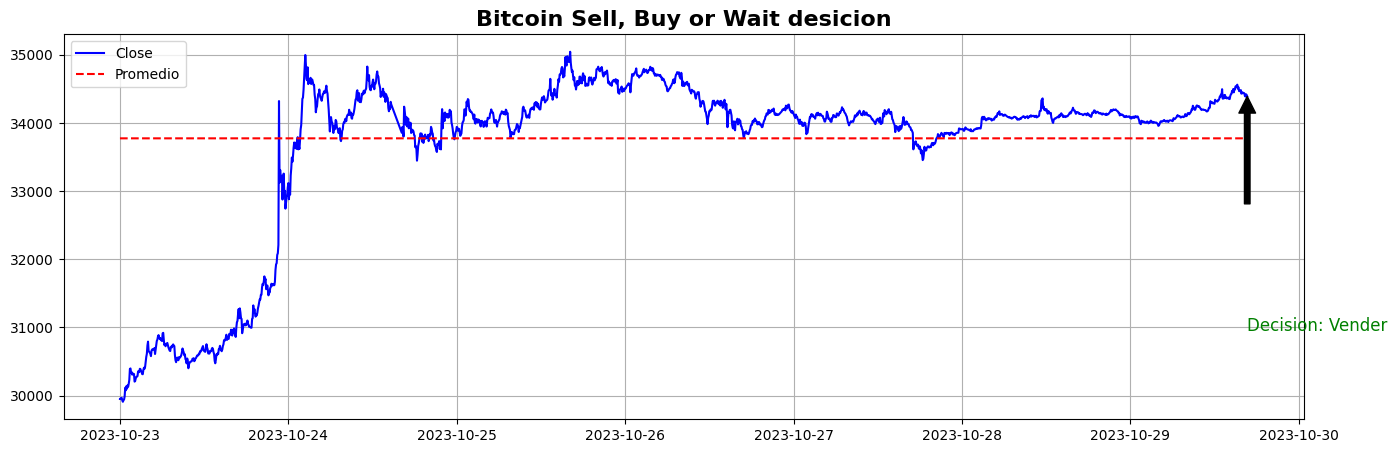

In [ ]:
from IPython.display import clear_output
import time

# Define an infinite loop for continuous execution
while True:
    # Clear the previous output to avoid displaying multiple graphs
    clear_output(wait=True)

    # Import Bitcoin data
    importar_base_bitcoin()

    # Extract trends
    extraer_tendencias()

    # Data cleaning
    limpieza_datos()

    # Make decisions
    tomar_decisiones()

    # Visualization
    visualizacion()

    # Pause the loop for 5 minutes before the next iteration
    time.sleep(300)
